In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from sklearn.externals import joblib
%matplotlib inline
import seaborn as sns

DIR = '/Users/szkfzx/datasets/home-credit-default-risk'

/Users/szkfzx/anaconda2/envs/python36/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
X = pd.read_csv(os.path.join(DIR,'application_train.csv'), nrows=None)
X.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


# Preprocessing
## Solution 3

[Martin Kotek (Competition Host): "Value 365243 denotes infinity in DAYS variables in the datasets, therefore you can consider them NA values. Also XNA/XAP denote NA values."](https://www.kaggle.com/c/home-credit-default-risk/discussion/57247)

In [4]:
X['CODE_GENDER'].unique()

array(['M', 'F', 'XNA'], dtype=object)

In [5]:
X.loc[X['DAYS_EMPLOYED'] > 0]['DAYS_EMPLOYED'].unique()

array([365243])

In [6]:
sum(X['ORGANIZATION_TYPE'] == 'XNA')

55374

In [7]:
X['CODE_GENDER'].value_counts()

F      202448
M      105059
XNA         4
Name: CODE_GENDER, dtype: int64

In [8]:
X['CODE_GENDER'].replace('XNA',np.nan, inplace=True)
X['CODE_GENDER'].value_counts()

F    202448
M    105059
Name: CODE_GENDER, dtype: int64

## Solution 5

In [9]:
X['DAYS_LAST_PHONE_CHANGE'].replace(0, np.nan, inplace=True)

# Feature Engineering
## Solution 3
### Hand crafted features

In [10]:
X['annuity_income_percentage'] = X['AMT_ANNUITY'] / X['AMT_INCOME_TOTAL']
X['car_to_birth_ratio'] = X['OWN_CAR_AGE'] / X['DAYS_BIRTH']
X['car_to_employ_ratio'] = X['OWN_CAR_AGE'] / X['DAYS_EMPLOYED']
X['children_ratio'] = X['CNT_CHILDREN'] / X['CNT_FAM_MEMBERS']
X['credit_to_annuity_ratio'] = X['AMT_CREDIT'] / X['AMT_ANNUITY']
X['credit_to_goods_ratio'] = X['AMT_CREDIT'] / X['AMT_GOODS_PRICE']
X['credit_to_income_ratio'] = X['AMT_CREDIT'] / X['AMT_INCOME_TOTAL']
X['days_employed_percentage'] = X['DAYS_EMPLOYED'] / X['DAYS_BIRTH']
X['income_credit_percentage'] = X['AMT_INCOME_TOTAL'] / X['AMT_CREDIT']
X['income_per_child'] = X['AMT_INCOME_TOTAL'] / (1 + X['CNT_CHILDREN'])
X['income_per_person'] = X['AMT_INCOME_TOTAL'] / X['CNT_FAM_MEMBERS']
X['payment_rate'] = X['AMT_ANNUITY'] / X['AMT_CREDIT']
X['phone_to_birth_ratio'] = X['DAYS_LAST_PHONE_CHANGE'] / X['DAYS_BIRTH']
X['phone_to_employ_ratio'] = X['DAYS_LAST_PHONE_CHANGE'] / X['DAYS_EMPLOYED']

In [11]:
# External sources
X['external_sources_weighted'] = X.EXT_SOURCE_1 * 2 + X.EXT_SOURCE_2 * 3 + X.EXT_SOURCE_3 * 4
for function_name in ['min', 'max', 'sum', 'mean', 'nanmedian']:
    X['external_sources_{}'.format(function_name)] = eval('np.{}'.format(function_name))(
        X[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']], axis=1)

/Users/szkfzx/anaconda2/envs/python36/lib/python3.6/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


In [12]:
engineered_numerical_columns = ['annuity_income_percentage',
                                'car_to_birth_ratio',
                                'car_to_employ_ratio',
                                'children_ratio',
                                'credit_to_annuity_ratio',
                                'credit_to_goods_ratio',
                                'credit_to_income_ratio',
                                'days_employed_percentage',
                                'income_credit_percentage',
                                'income_per_child',
                                'income_per_person',
                                'payment_rate',
                                'phone_to_birth_ratio',
                                'phone_to_employ_ratio',
                                'external_sources_weighted',
                                'external_sources_min',
                                'external_sources_max',
                                'external_sources_sum',
                                'external_sources_mean',
                                'external_sources_nanmedian']

In [13]:
X_eng = X[engineered_numerical_columns + ['TARGET']]
X_eng_corr = abs(X_eng.corr())

In [14]:
X_eng_corr.sort_values('TARGET', ascending=False)['TARGET']

TARGET                        1.000000
external_sources_weighted     0.236289
external_sources_mean         0.222052
external_sources_nanmedian    0.218118
external_sources_max          0.196876
external_sources_min          0.185266
external_sources_sum          0.173322
credit_to_goods_ratio         0.069427
car_to_birth_ratio            0.048824
days_employed_percentage      0.042206
credit_to_annuity_ratio       0.032102
car_to_employ_ratio           0.030553
phone_to_birth_ratio          0.029550
children_ratio                0.021223
annuity_income_percentage     0.014265
payment_rate                  0.012704
income_per_child              0.012529
credit_to_income_ratio        0.007727
phone_to_employ_ratio         0.006714
income_per_person             0.006571
income_credit_percentage      0.001817
Name: TARGET, dtype: float64

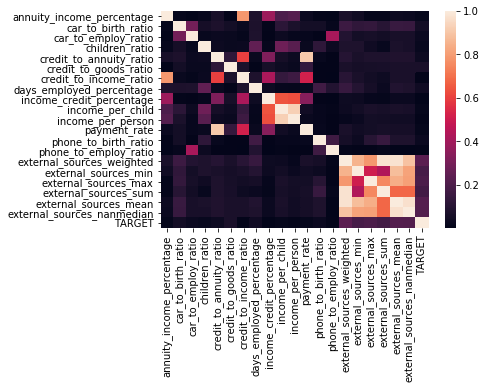

In [15]:
sns.heatmap(X_eng_corr, 
            xticklabels=X_eng_corr.columns,
            yticklabels=X_eng_corr.columns)

### Aggregation features

In [16]:
AGGREGATION_RECIPIES = [
    (['CODE_GENDER', 'NAME_EDUCATION_TYPE'], [('AMT_ANNUITY', 'max'),
                                              ('AMT_CREDIT', 'max'),
                                              ('EXT_SOURCE_1', 'mean'),
                                              ('EXT_SOURCE_2', 'mean'),
                                              ('OWN_CAR_AGE', 'max'),
                                              ('OWN_CAR_AGE', 'sum')]),
    (['CODE_GENDER', 'ORGANIZATION_TYPE'], [('AMT_ANNUITY', 'mean'),
                                            ('AMT_INCOME_TOTAL', 'mean'),
                                            ('DAYS_REGISTRATION', 'mean'),
                                            ('EXT_SOURCE_1', 'mean')]),
    (['CODE_GENDER', 'REG_CITY_NOT_WORK_CITY'], [('AMT_ANNUITY', 'mean'),
                                                 ('CNT_CHILDREN', 'mean'),
                                                 ('DAYS_ID_PUBLISH', 'mean')]),
    (['CODE_GENDER', 'NAME_EDUCATION_TYPE', 'OCCUPATION_TYPE', 'REG_CITY_NOT_WORK_CITY'], [('EXT_SOURCE_1', 'mean'),
                                                                                           ('EXT_SOURCE_2', 'mean')]),
    (['NAME_EDUCATION_TYPE', 'OCCUPATION_TYPE'], [('AMT_CREDIT', 'mean'),
                                                  ('AMT_REQ_CREDIT_BUREAU_YEAR', 'mean'),
                                                  ('APARTMENTS_AVG', 'mean'),
                                                  ('BASEMENTAREA_AVG', 'mean'),
                                                  ('EXT_SOURCE_1', 'mean'),
                                                  ('EXT_SOURCE_2', 'mean'),
                                                  ('EXT_SOURCE_3', 'mean'),
                                                  ('NONLIVINGAREA_AVG', 'mean'),
                                                  ('OWN_CAR_AGE', 'mean'),
                                                  ('YEARS_BUILD_AVG', 'mean')]),
    (['NAME_EDUCATION_TYPE', 'OCCUPATION_TYPE', 'REG_CITY_NOT_WORK_CITY'], [('ELEVATORS_AVG', 'mean'),
                                                                            ('EXT_SOURCE_1', 'mean')]),
    (['OCCUPATION_TYPE'], [('AMT_ANNUITY', 'mean'),
                           ('CNT_CHILDREN', 'mean'),
                           ('CNT_FAM_MEMBERS', 'mean'),
                           ('DAYS_BIRTH', 'mean'),
                           ('DAYS_EMPLOYED', 'mean'),
                           ('DAYS_ID_PUBLISH', 'mean'),
                           ('DAYS_REGISTRATION', 'mean'),
                           ('EXT_SOURCE_1', 'mean'),
                           ('EXT_SOURCE_2', 'mean'),
                           ('EXT_SOURCE_3', 'mean')]),
]

In [17]:
groupby_aggregate_names = []
for groupby_cols, specs in tqdm(AGGREGATION_RECIPIES):
    group_object = X.groupby(groupby_cols)
    for select, agg in tqdm(specs):
        groupby_aggregate_name = '{}_{}_{}'.format('_'.join(groupby_cols), agg, select)
        X = X.merge(group_object[select]
                              .agg(agg)
                              .reset_index()
                              .rename(index=str,
                                      columns={select: groupby_aggregate_name})
                              [groupby_cols + [groupby_aggregate_name]],
                              on=groupby_cols,
                              how='left')
        groupby_aggregate_names.append(groupby_aggregate_name)

In [18]:
X_agg = X[groupby_aggregate_names + ['TARGET']]
X_agg_corr = abs(X_agg.corr())

In [19]:
X_agg_corr.sort_values('TARGET', ascending=False)['TARGET']

TARGET                                                                                      1.000000
NAME_EDUCATION_TYPE_OCCUPATION_TYPE_REG_CITY_NOT_WORK_CITY_mean_EXT_SOURCE_1                0.089964
CODE_GENDER_NAME_EDUCATION_TYPE_OCCUPATION_TYPE_REG_CITY_NOT_WORK_CITY_mean_EXT_SOURCE_2    0.089231
CODE_GENDER_NAME_EDUCATION_TYPE_OCCUPATION_TYPE_REG_CITY_NOT_WORK_CITY_mean_EXT_SOURCE_1    0.086677
NAME_EDUCATION_TYPE_OCCUPATION_TYPE_mean_EXT_SOURCE_1                                       0.083520
NAME_EDUCATION_TYPE_OCCUPATION_TYPE_mean_EXT_SOURCE_2                                       0.082742
NAME_EDUCATION_TYPE_OCCUPATION_TYPE_REG_CITY_NOT_WORK_CITY_mean_ELEVATORS_AVG               0.078057
OCCUPATION_TYPE_mean_EXT_SOURCE_1                                                           0.076587
NAME_EDUCATION_TYPE_OCCUPATION_TYPE_mean_AMT_REQ_CREDIT_BUREAU_YEAR                         0.074528
NAME_EDUCATION_TYPE_OCCUPATION_TYPE_mean_YEARS_BUILD_AVG                                   

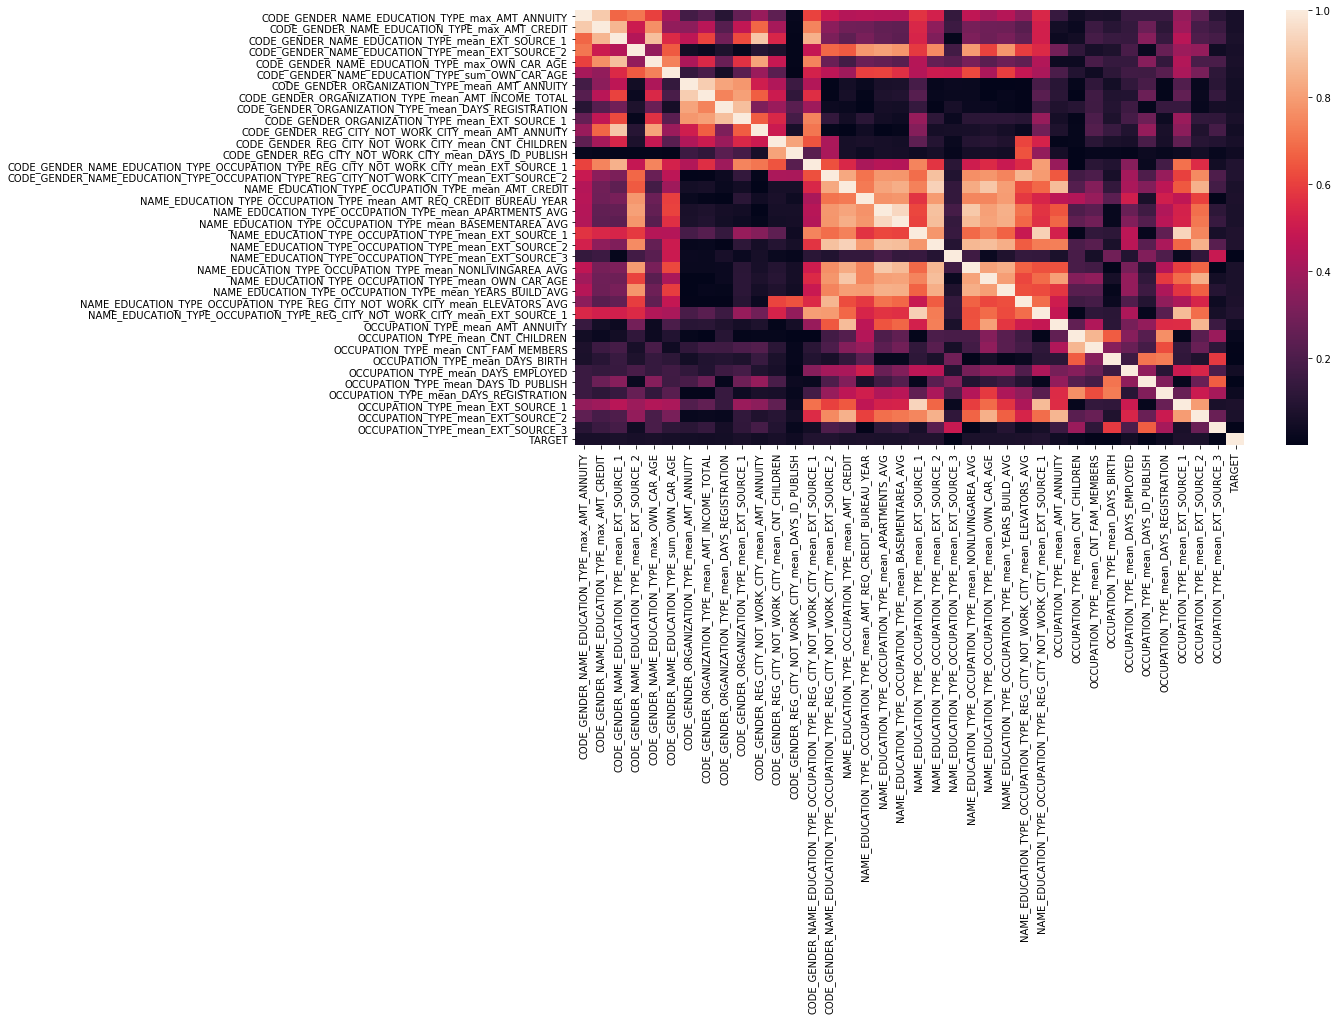

In [20]:
plt.figure(figsize=(15,8))
sns.heatmap(X_agg_corr, 
            xticklabels=X_agg_corr.columns,
            yticklabels=X_agg_corr.columns)

## Solution 4 
### Hand crafted features
* diff features

In [21]:
diff_feature_names = []
for groupby_cols, specs in tqdm(AGGREGATION_RECIPIES):
    for select, agg in tqdm(specs):
        if agg in ['mean','median','max','min']:
            groupby_aggregate_name = '{}_{}_{}'.format('_'.join(groupby_cols), agg, select)
            diff_name = '{}_diff'.format(groupby_aggregate_name)
            abs_diff_name = '{}_abs_diff'.format(groupby_aggregate_name)

            X[diff_name] = X[select] - X[groupby_aggregate_name] 
            X[abs_diff_name] = np.abs(X[select] - X[groupby_aggregate_name]) 

            diff_feature_names.append(diff_name)
            diff_feature_names.append(abs_diff_name)

In [22]:
X_diff = X[diff_feature_names + ['TARGET']]
X_diff_corr = abs(X_diff.corr())
X_diff_corr.sort_values('TARGET', ascending=False)['TARGET']

TARGET                                                                                               1.000000
NAME_EDUCATION_TYPE_OCCUPATION_TYPE_mean_EXT_SOURCE_3_diff                                           0.180676
OCCUPATION_TYPE_mean_EXT_SOURCE_3_diff                                                               0.180197
OCCUPATION_TYPE_mean_EXT_SOURCE_2_diff                                                               0.162917
NAME_EDUCATION_TYPE_OCCUPATION_TYPE_mean_EXT_SOURCE_2_diff                                           0.159719
CODE_GENDER_NAME_EDUCATION_TYPE_OCCUPATION_TYPE_REG_CITY_NOT_WORK_CITY_mean_EXT_SOURCE_2_diff        0.157282
CODE_GENDER_NAME_EDUCATION_TYPE_mean_EXT_SOURCE_2_diff                                               0.153519
CODE_GENDER_ORGANIZATION_TYPE_mean_EXT_SOURCE_1_diff                                                 0.145575
CODE_GENDER_NAME_EDUCATION_TYPE_mean_EXT_SOURCE_1_diff                                               0.142056
OCCUPATION

* unemployed

In [23]:
X['DAYS_EMPLOYED'].replace(365243,np.nan, inplace=True)

In [24]:
X_clean = X[~pd.isnull(X['DAYS_EMPLOYED'])]

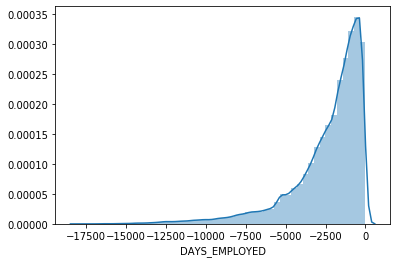

In [25]:
sns.distplot(X_clean['DAYS_EMPLOYED'])

In [26]:
X['DAYS_EMPLOYED'].describe()

count    252137.000000
mean      -2384.169325
std        2338.360162
min      -17912.000000
25%       -3175.000000
50%       -1648.000000
75%        -767.000000
max           0.000000
Name: DAYS_EMPLOYED, dtype: float64

In [27]:
X['long_employment'] = (X['DAYS_EMPLOYED'] < -2000).astype(int)
feature_names = ['long_employment']

In [28]:
X_employment = X[feature_names +['DAYS_EMPLOYED'] + ['TARGET']]
X_employment_corr = abs(X_employment.corr())
X_employment_corr.sort_values('TARGET', ascending=False)['TARGET']

TARGET             1.000000
DAYS_EMPLOYED      0.074958
long_employment    0.049197
Name: TARGET, dtype: float64

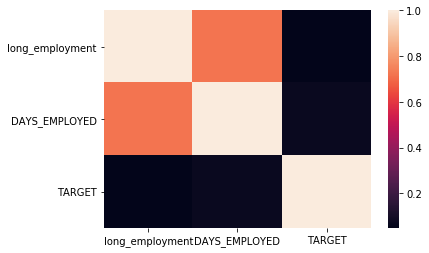

In [29]:
sns.heatmap(X_employment_corr, 
            xticklabels=X_employment_corr.columns,
            yticklabels=X_employment_corr.columns)

* age binns

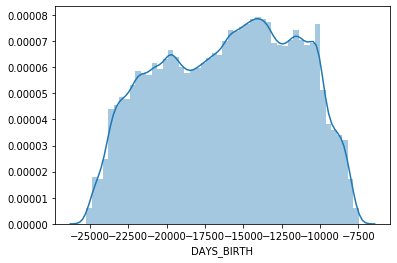

In [30]:
sns.distplot(X['DAYS_BIRTH'])

In [31]:
X['retirement_age'] = (X['DAYS_BIRTH'] < -14000).astype(int)
feature_names = ['DAYS_BIRTH','retirement_age']

In [32]:
X_age = X[feature_names + ['DAYS_BIRTH'] + ['TARGET']]
X_age_corr = abs(X_age.corr())
X_age_corr.sort_values('TARGET', ascending=False)['TARGET']

TARGET            1.000000
DAYS_BIRTH        0.078239
DAYS_BIRTH        0.078239
retirement_age    0.067615
Name: TARGET, dtype: float64

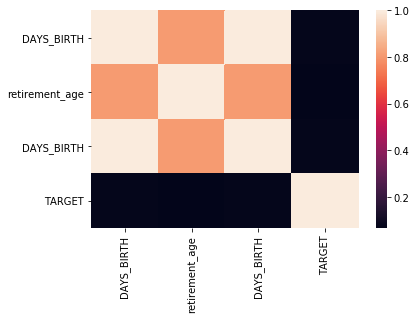

In [33]:
sns.heatmap(X_age_corr, 
            xticklabels=X_age_corr.columns,
            yticklabels=X_age_corr.columns)

# Solution 5
## Hand Crafted

In [34]:
X['cnt_non_child'] = X['CNT_FAM_MEMBERS'] - X['CNT_CHILDREN']
X['child_to_non_child_ratio'] = X['CNT_CHILDREN'] / X['cnt_non_child']
X['income_per_non_child'] = X['AMT_INCOME_TOTAL'] / X['cnt_non_child']
X['credit_per_person'] = X['AMT_CREDIT'] / X['CNT_FAM_MEMBERS']
X['credit_per_child'] = X['AMT_CREDIT'] / (1 + X['CNT_CHILDREN'])
X['credit_per_non_child'] = X['AMT_CREDIT'] / X['cnt_non_child']

In [35]:
feature_names = ['cnt_non_child',
                 'child_to_non_child_ratio',
                 'income_per_non_child',
                 'credit_per_person',
                 'credit_per_child',
                 'credit_per_non_child']

In [36]:
X_family = X[feature_names + ['TARGET']]
X_family_corr = abs(X_family.corr())
X_family_corr.sort_values('TARGET', ascending=False)['TARGET']

TARGET                      1.000000
credit_per_child            0.033503
credit_per_person           0.023462
child_to_non_child_ratio    0.020943
credit_per_non_child        0.020244
cnt_non_child               0.012195
income_per_non_child        0.001947
Name: TARGET, dtype: float64